In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("train.csv", parse_dates=['datetime'])

In [3]:
data['year'] = data['datetime'].dt.year.astype(int)
data['month'] = data['datetime'].dt.month.astype(int)
data['day_name'] = data['datetime'].dt.day.astype(int)
data['hour'] = data['datetime'].dt.hour.astype(int)
data['is_weekend'] = data['day_name'].isin(['Saturday', 'Sunday']).astype(int)

bins = [0, 6, 12, 18, 24]
labels = [1, 2, 3, 4]
data['day_period'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False).astype(int)

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day_name,hour,is_weekend,day_period
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,1


In [5]:
data.shape

(10886, 18)

In [6]:
data.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int32
month                  int32
day_name               int32
hour                   int32
is_weekend             int32
day_period             int32
dtype: object

In [7]:
X = data.drop(columns=['count', 'datetime'])
y = data['count']

In [8]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

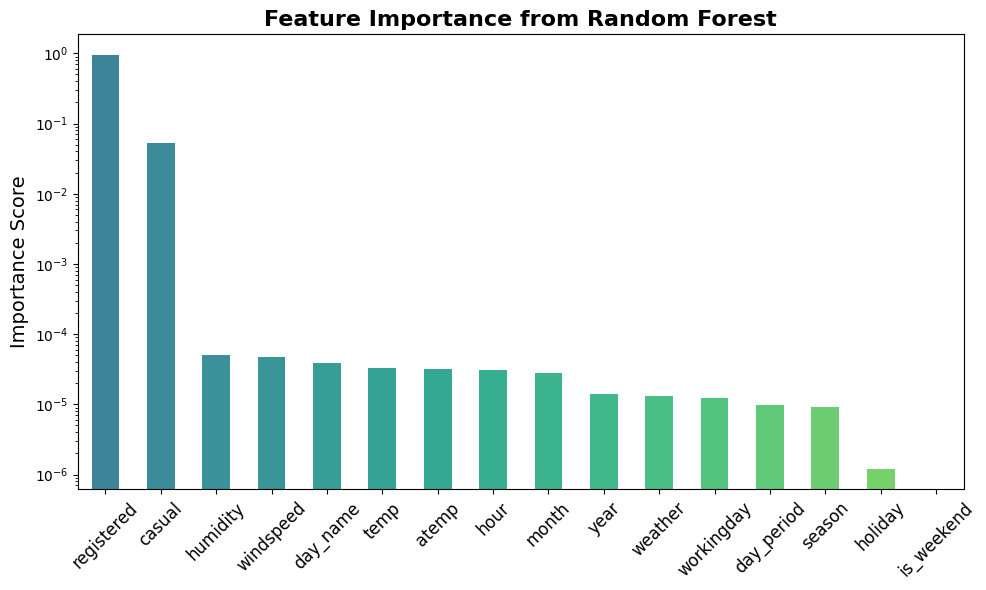

registered    0.946992
casual        0.052689
humidity      0.000050
windspeed     0.000047
day_name      0.000039
temp          0.000033
atemp         0.000032
hour          0.000031
month         0.000028
year          0.000014
weather       0.000013
workingday    0.000012
day_period    0.000010
season        0.000009
holiday       0.000001
is_weekend    0.000000
dtype: float64


In [9]:
colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(feature_importances)))

plt.figure(figsize=(10, 6))
bars = feature_importances.plot(kind='bar', color=colors, alpha=0.9)

plt.yscale('log')

plt.title('Feature Importance from Random Forest', fontsize=16, fontweight='bold')
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

print(feature_importances)

In [10]:
model = LinearRegression()

selector = RFE(model, n_features_to_select=10, step=1)
selector.fit(X, y)

selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['season', 'holiday', 'workingday', 'weather', 'atemp', 'casual',
       'registered', 'year', 'hour', 'day_period'],
      dtype='object')


In [11]:
m = MINE()

mic_scores = {}
for col in X.columns:
    m.compute_score(X[col], y)
    mic_scores[col] = m.mic()

mic_df = pd.DataFrame(list(mic_scores.items()), columns=['Feature', 'MIC']).sort_values(by='MIC', ascending=False)

print(mic_df)

       Feature       MIC
9   registered  0.895985
8       casual  0.561410
13        hour  0.522467
15  day_period  0.494300
5        atemp  0.140051
4         temp  0.137850
6     humidity  0.100955
10        year  0.095907
0       season  0.078259
11       month  0.078259
2   workingday  0.051605
7    windspeed  0.044450
3      weather  0.042873
12    day_name  0.033936
1      holiday  0.026715
14  is_weekend  0.000000


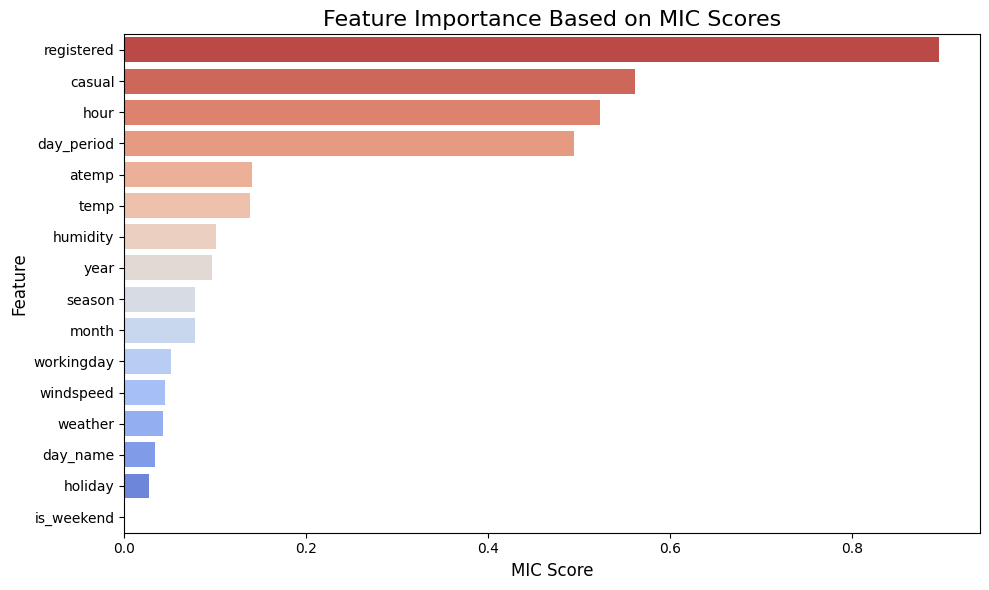

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='MIC', 
            y='Feature', 
            hue='Feature', 
            data=mic_df, 
            palette='coolwarm_r', 
            dodge=False, 
            saturation=0.8)

plt.title('Feature Importance Based on MIC Scores', fontsize=16)
plt.xlabel('MIC Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

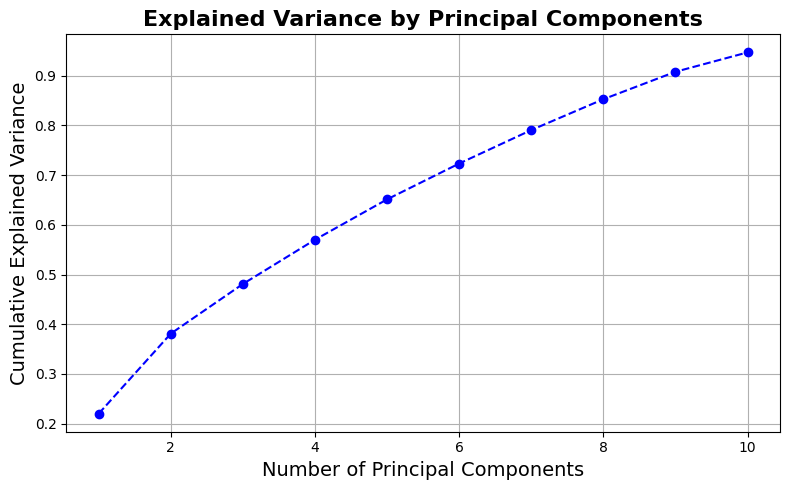

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title('Explained Variance by Principal Components', fontsize=16, fontweight='bold')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

In [24]:
features = data[['registered', 'casual', 'hour', 'atemp', 'humidity', 'season', 'weather', 'workingday']]